In [26]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

from create_dataframes import dataframe_standard, dataframe_all, create_df_detailed
from path_util import data_path
from viz_reg import robust_regression, multivariate_regression, simple_linear_regression, viz_sideways, relative_positive_negative, viz_gender_target, completeness_detailed

## Import the processed dataframe with detailed occupations only

In [2]:
df_detailed = create_df_detailed()

df_detailed.head(3)

,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,men,women,white,non_hispanic_white,african_american,asian,hispanic,education_slope,A_MEAN,A_MEDIAN
0,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...",1,0.026316,"{""Chief executive officer"": [{""revid"": 6437689...",1756.0,"{""Chief executive officer"": 17489}",17489.0,0.709,0.291,0.857,0.783,0.059,0.068,0.074,2.596429,213020,179520
1,11-1021,detailed,General and Operations Managers,"[[""General manager"", ""http://en.wikipedia.org/...",2,0.052632,"{""General manager"": [{""revid"": 749862417, ""use...",412.5,"{""General manager"": 7116, ""Operations manageme...",38205.5,0.636,0.364,0.827,0.724,0.093,0.046,0.103,-0.235714,115250,97970
2,11-2021,detailed,Marketing Managers,"[[""Marketing management"", ""http://en.wikipedia...",2,0.052632,"{""Marketing management"": [{""revid"": 837236871,...",354.5,"{""Marketing management"": 16750, ""Chief marketi...",12016.0,0.386,0.614,0.835,0.752,0.062,0.073,0.083,3.207143,153440,135030


In [25]:
list(df_detailed.columns) # all variables

['occ_code',
 'occ_group',
 'occ_title',
 'lenient_links',
 'amount_art',
 'art_per_detailed',
 'lenient_revs',
 'avg_unique_auths',
 'lenient_lengths',
 'avg_art_lengths',
 'men',
 'women',
 'white',
 'non_hispanic_white',
 'african_american',
 'asian',
 'hispanic',
 'education_slope',
 'A_MEAN',
 'A_MEDIAN']

### Variable Explanation

'amount_art', 'art_per_detailed', 'avg_unique_auths', 'avg_art_lengths' are the metrics computed from the wikipedia revision data. amount_art is the amount of articles in a given category, art_per_detailed is amount_art divided by the number of detailed occupations in the category,  avg_unique_auths is how many (unique) authors work on a given site on average and avg_art_lengths are the average lengths of wiki sites in a category.

'men', 'women', 'white', 'non_hispanic_white', 'african_american', 'asian', 'hispanic' is the (average) rate of people belonging to a gender/race/ethnicity within a given category. The summed versions of these are computed by only computing the average with the detailed occupations that have a site matched to them.

'A_MEAN', 'A_MEDIAN' are the annual mean and median income for the category.

'education_slope' represents the slope between 8 ordered rates of education for a given occupation group. (more info in the scripts)

### EDA

##### The following visualization shows for how many of all detailed occupations there is at least 1 Wikipedia site in the dataframe

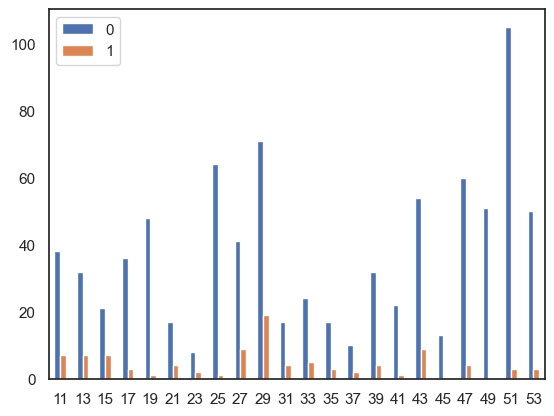

In [9]:
completeness_detailed(dataframe_all())

We can see that only a small number of all detailed occupations is actually represented in our data, which is a major limitation/drawback for this analysis. In total, after removing all missings, only about 100 detailed (of 831 detailed occupations in total) are represented in our data. 

### Simple Linear Regression

Pearsons correlation is 0.706
The p-value is 4.845780386843807e-16


                            OLS Regression Results                            
Dep. Variable:               A_MEDIAN   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     95.28
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           4.85e-16
Time:                        15:47:24   Log-Likelihood:                -1117.0
No. Observations:                  98   AIC:                             2238.
Df Residuals:                      96   BIC:                             2243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

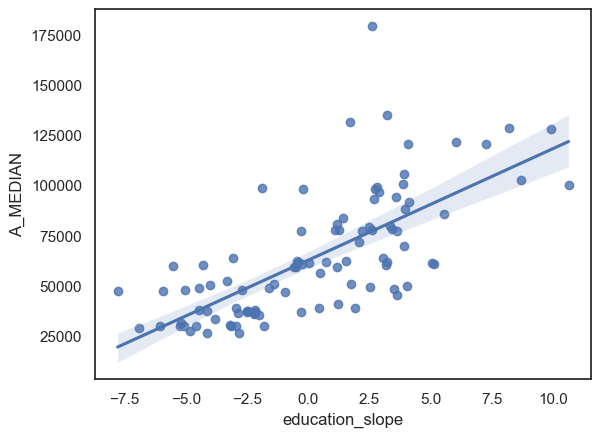

In [10]:
simple_linear_regression(df_detailed, "A_MEDIAN", "education_slope") # proof that education increases salary

### Multivariate Regression

##### In the col_list, we can include any number of variables, for instance for which to control for.
##### Watch out for colinearity!

                            OLS Regression Results                            
Dep. Variable:       avg_unique_auths   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     15.24
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           3.70e-08
Time:                        15:57:20   Log-Likelihood:                -732.04
No. Observations:                  98   AIC:                             1472.
Df Residuals:                      94   BIC:                             1482.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1043.3670    120.867  

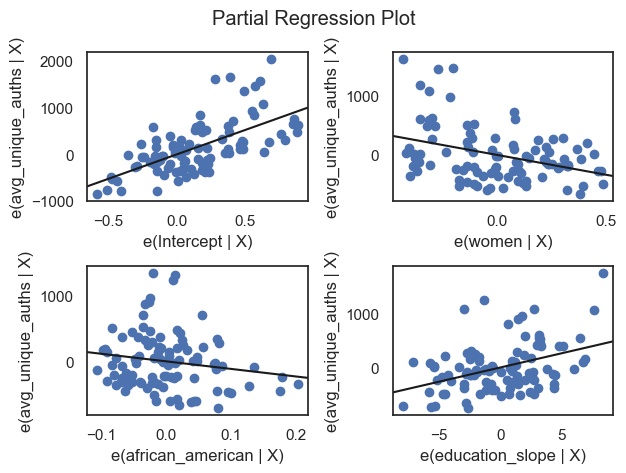

In [13]:
col_list = ["avg_unique_auths", "women", "african_american", "education_slope"]

multivariate_regression(df_detailed, col_list)

Depending on the chosen variables, we can observe some significant bias in the Wikipedia revision data. R-squared is usually in the medium/low range, between 0.2 and 0.4.

### Correlation Matrix

##### Shows the correlation between all variables in the df_major. Note that only some of these correlations are actually relevant (e.g., the correlation between %women and %men is perfectly linear for obvious reasons.)

<AxesSubplot:>

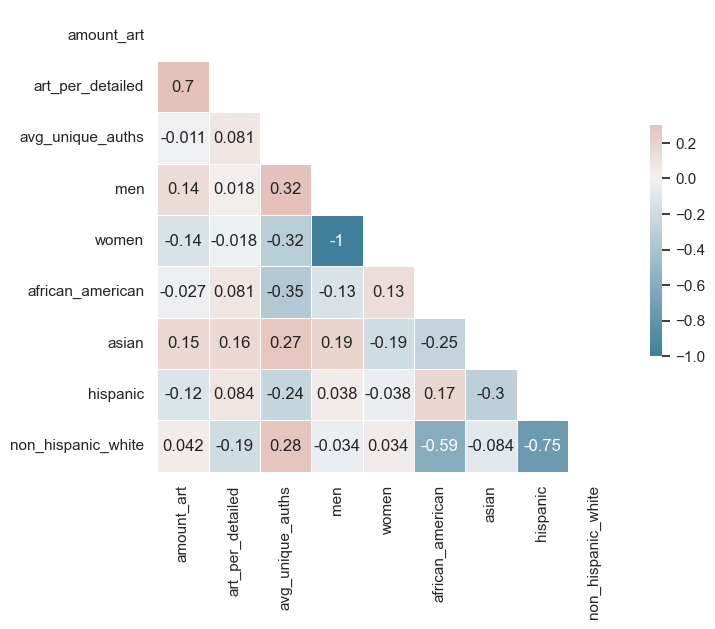

In [23]:
sns.set_theme(style="white")

corr_df = df_detailed[["amount_art", "art_per_detailed", "avg_unique_auths", 
                       "men", "women", "african_american", 
                       "asian", "hispanic", "non_hispanic_white"]].apply(pd.to_numeric)
corr_df.dropna(inplace = True)
corr = corr_df.corr(min_periods = 0)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlations are not very high. Partially, it was assumed that this is because a lack of data. However, the avg_unique_auths column shows that it wiki sites with high rates of non-hispanic whites and men have more authors working on them. This is in line with the hypothesis that the demographics of wikipedia editors results in a certain bias. 